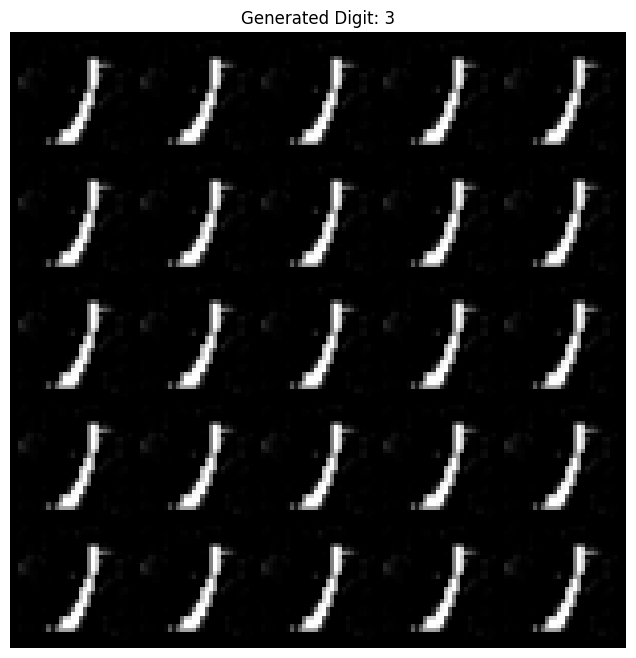

Saved sample grid to: results\samples\notebook_digit_3.png


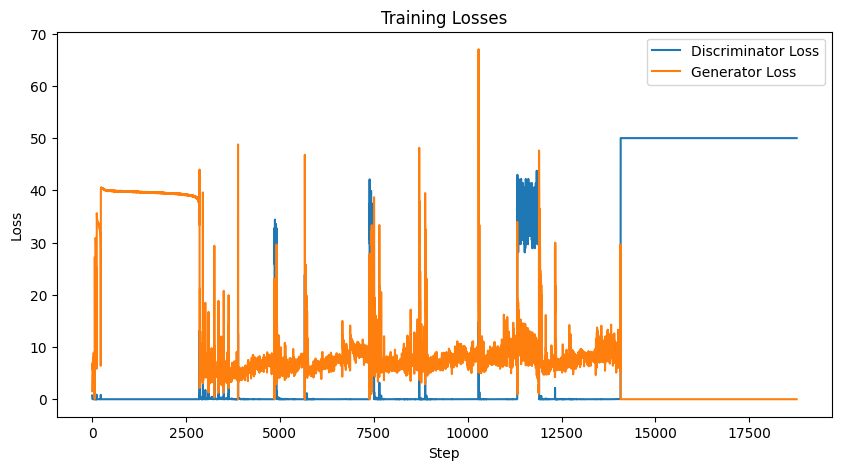

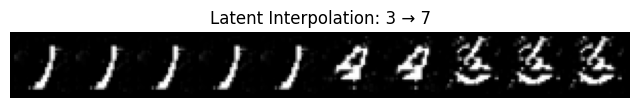

In [2]:
# %% [markdown]
# # Conditional GAN (CGAN) on MNIST
# 
# This notebook showcases the trained Conditional GAN (CGAN) for MNIST digit generation.
# 
# **Features:**
# - Generate digit-specific samples from saved checkpoints
# - Visualize generator and discriminator losses
# - Optional: Latent space interpolation between digits

# %%
# Ensure torch and torchvision are available in the notebook environment


import torch
from pathlib import Path
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import pandas as pd
from src.models.generator import Generator
from src.models.discriminator import Discriminator
from config import Z_DIM, NUM_CLASSES, IMG_SHAPE, CHECKPOINTS_DIR, RESULTS_DIR, SAMPLES_DIR, DEVICE, EPOCHS

# %% [markdown]
# ## Utility Functions

# %%
def show_images(img_tensor, nrow=5, title=None):
    grid = make_grid(img_tensor, nrow=nrow, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def load_generator(epoch=EPOCHS, device=DEVICE):
    # use img_channels instead of img_shape
    G = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, img_channels=IMG_SHAPE[0]).to(device)
    ckpt_path = Path(CHECKPOINTS_DIR) / f"generator_epoch_{epoch:03d}.pth"
    G.load_state_dict(torch.load(ckpt_path, map_location=device))
    G.eval()
    return G


# %% [markdown]
# ## 1️⃣ Generate Samples by Digit

# %%
device = DEVICE
generator = load_generator(epoch=EPOCHS, device=device)

digit = 3
count = 25
noise = torch.randn(count, Z_DIM, device=device)
labels = torch.full((count,), digit, dtype=torch.long, device=device)

with torch.no_grad():
    samples = generator(noise, labels).cpu()

# Show and save
show_images(samples, nrow=5, title=f"Generated Digit: {digit}")
save_path = Path(SAMPLES_DIR) / f"notebook_digit_{digit}.png"
save_image(samples, save_path, nrow=5, normalize=True)
print(f"Saved sample grid to: {save_path}")

# %% [markdown]
# ## 2️⃣ Training Curves

# %%
# Load training log
log_path = Path(RESULTS_DIR) / "training_log.csv"
df = pd.read_csv(log_path)

plt.figure(figsize=(10,5))
plt.plot(df['step'], df['d_loss'], label='Discriminator Loss')
plt.plot(df['step'], df['g_loss'], label='Generator Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# %% [markdown]
# ## 3️⃣ Optional: Latent Space Interpolation
# Interpolate between two digits in latent space

# %%
digit_start, digit_end = 3, 7
steps = 10

noise_start = torch.randn(1, Z_DIM, device=device)
noise_end = torch.randn(1, Z_DIM, device=device)
labels_start = torch.tensor([digit_start], device=device)
labels_end = torch.tensor([digit_end], device=device)

interpolated_images = []
for alpha in torch.linspace(0, 1, steps):
    noise_interp = (1-alpha)*noise_start + alpha*noise_end
    label_interp = (1-alpha)*labels_start + alpha*labels_end
    label_interp = label_interp.long()
    with torch.no_grad():
        img = generator(noise_interp, label_interp).cpu()
    interpolated_images.append(img)

interpolated_images = torch.cat(interpolated_images)
show_images(interpolated_images, nrow=steps, title=f"Latent Interpolation: {digit_start} → {digit_end}")
